In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pylab as plt
import numpy as np  
# import matplotlib #don't delete!

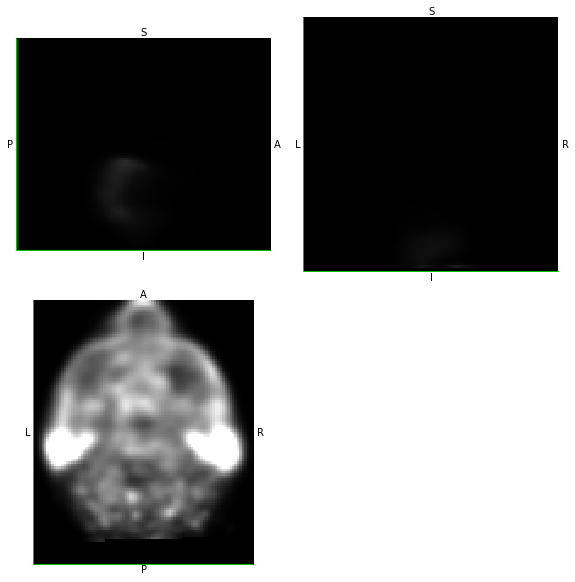

(91, 109, 91)

In [2]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "./datasets/A4/A4_aligned/B10018169/Florbetapir/cmeanA4_B10018169_MR_Florbetapir_Br_20200720182306561_S893044_I1321166.nii.gz"
 
img = nib.load(example_filename)
OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape

In [3]:
###set target_dict
filename="A4_SUBJINFO_PRV2"
tc="AGEYR"
pf=lambda x:x
cls_num=1 #1 is reg

# filename="A4_SUBJINFO_PRV2"
# tc="APOEGN"
# labels=[
#     "E2/E2",
#     "E2/E3",
#     "E2/E4",
#     "E3/E3",
#     "E3/E4",
#     "E4/E4"
# ]
# pf=lambda x:{
#     # "NA":0,
#     labels[i]:i for i in range(len(labels))
#     }[x]
tg_dict={
    "filename":filename,
    "target_column":tc,
    "prefunc":pf
}

In [4]:
from dataloader.A4 import preprocess_save_img,load_data
from sklearn.model_selection import train_test_split,KFold

x,y=load_data(filename+".csv",tc,max_size=-1)
# pre_fy=lambda y:1 if y=="positive" else 0
# dataset=(x,y)
x_train,x_test=train_test_split(
    x,test_size=0.1,random_state=1919810
)
x_train,x_val=train_test_split(
    x_train,test_size=0.05,random_state=114514
)

train_data_dir="datasets/A4/train"
val_data_dir="datasets/A4/val"
test_data_dir="datasets/A4/test"

train_data_file=preprocess_save_img(x_train,train_data_dir,4)
val_data_file=preprocess_save_img(x_val,val_data_dir)
test_data_file=preprocess_save_img(x_test,test_data_dir)

# train_d,val_d,test_d=(
#     A4Dataset_train(x_train,y_train,ag_rate=4,batch_size=64,pre_fy=pre_fy),
#     A4Dataset_test(x_val,y_val,batch_size=64,pre_fy=pre_fy),
#     A4Dataset_test(x_test,y_test,batch_size=64,pre_fy=pre_fy)
# )

print("Train imgs:",len(x_train))
print("Val imgs:",len(x_val))
print("Test imgs:",len(x_test))

# kf = KFold(n_splits=10)

100%|██████████| 6945/6945 [00:04<00:00, 1532.47it/s]


Total data number:4337
unusable BID:['B10048838', 'B10082310', 'B10087409', 'B10116545', 'B10120577', 'B10161786', 'B10216041', 'B10250828', 'B10297864', 'B10314311', 'B10375785', 'B10466532', 'B10470395', 'B10475432', 'B10566568', 'B10580593', 'B10586719', 'B10629565', 'B10631248', 'B10667552', 'B10681577', 'B10724240', 'B10803855', 'B10812124', 'B10820340', 'B10898478', 'B10960121', 'B11013022', 'B11015768', 'B11043919', 'B11070282', 'B11077812', 'B11084242', 'B11135248', 'B11168665', 'B11187381', 'B11238033', 'B11245794', 'B11255389', 'B11322811', 'B11356244', 'B11389829', 'B11392215', 'B11414481', 'B11451752', 'B11500179', 'B11508488', 'B11585662', 'B11767634', 'B11776660', 'B11820299', 'B11840262', 'B11880369', 'B11883691', 'B11894979', 'B11913942', 'B11941178', 'B11941338', 'B11976238', 'B11980308', 'B11989910', 'B11999292', 'B12096187', 'B12108081', 'B12115504', 'B12117837', 'B12121724', 'B12265847', 'B12323374', 'B12324910', 'B12331417', 'B12340275', 'B12366573', 'B12384965', '

100%|██████████| 3707/3707 [04:50<00:00, 12.74it/s]


(18535, 42, 50, 42)


100%|██████████| 196/196 [01:10<00:00,  2.78it/s]


(196, 42, 50, 42)


100%|██████████| 434/434 [00:22<00:00, 19.35it/s]


(434, 42, 50, 42)
Train imgs: 3707
Val imgs: 196
Test imgs: 434


In [5]:
### make target data
from dataloader.A4 import preprocess_save_target
train_data_dir="datasets/A4/train"
val_data_dir="datasets/A4/val"
test_data_dir="datasets/A4/test"

train_target_file=preprocess_save_target(train_data_dir,**tg_dict)
val_target_file=preprocess_save_target(val_data_dir,**tg_dict)
test_target_file=preprocess_save_target(test_data_dir,**tg_dict)

print(train_target_file)
print(val_target_file)
print(test_target_file)


(18535,)
(196,)
(434,)
datasets/A4/train/target.npy
datasets/A4/val/target.npy
datasets/A4/test/target.npy


In [6]:
train_data_dir="datasets/A4/train"
val_data_dir="datasets/A4/val"
test_data_dir="datasets/A4/test"
train_data_file,val_data_file,test_data_file=(
    "datasets/A4/train/dataset.npy",
    "datasets/A4/val/dataset.npy",
    "datasets/A4/test/dataset.npy")

train_target_file,val_target_file,test_target_file=(
    "datasets/A4/train/target.npy",
    "datasets/A4/val/target.npy",
    "datasets/A4/test/target.npy")

In [7]:
from tensorflow.keras import callbacks
import numpy as np
from units.basefunc import save_model
from units.model import CNN3D

cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=CNN3D(cls_num)
history=model.fit(
    x=np.load(train_data_file,"r"),
    y=np.load(train_target_file,"r"),
    batch_size=64,epochs=30,callbacks=cb,
    validation_data=(np.load(val_data_file,"r"),np.load(val_target_file,"r"))
)

# model.variables.append()
save_model(model,**tg_dict)
# save_model_dir=os.path.join("models",filename+'_'+tc)
# save_model_name="m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime()))
# model.save(os.path.join(save_model_dir,save_model_name))
# model.save("./models/latest.h5")


Epoch 1/30
290/290 [==============================] - 24s 70ms/step - loss: 4813.0664 - root_mean_squared_error: 69.3763 - val_loss: 4414.6694 - val_root_mean_squared_error: 66.4430- loss: 4878.0728 - root_mean_squared - ETA: 2s - loss: 4859.4170 - root_me - ETA: 0s - loss: 4820.8149 - root_mean_squared_error: 
Epoch 2/30
290/290 [==============================] - 20s 68ms/step - loss: 2413.1443 - root_mean_squared_error: 49.1238 - val_loss: 262.5433 - val_root_mean_squared_error: 16.2032
Epoch 3/30
290/290 [==============================] - 20s 68ms/step - loss: 260.1844 - root_mean_squared_error: 16.1302 - val_loss: 348.6698 - val_root_mean_squared_error: 18.6727
Epoch 4/30
290/290 [==============================] - 20s 68ms/step - loss: 169.9634 - root_mean_squared_error: 13.0370 - val_loss: 276.5294 - val_root_mean_squared_error: 16.6292
Epoch 5/30
290/290 [==============================] - 20s 68ms/step - loss: 118.2491 - root_mean_squared_error: 10.8742 - val_loss: 213.1285 - val

In [8]:
### advanced learn
from tensorflow.keras.models import load_model
from units.basefunc import save_model
from tensorflow.keras import callbacks

cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
# model=load_model("./models/latest.h5")
history=model.fit(
    x=np.load(train_data_file,"r"),
    y=np.load(train_target_file,"r"),
    batch_size=64,epochs=20,callbacks=cb,
    validation_data=(np.load(val_data_file,"r"),np.load(val_target_file,"r"))
)

save_model(model,**tg_dict)
# save_model_dir=os.path.join("models",filename+'_'+tc)
# save_model_name="m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime()))
# model.save(os.path.join(save_model_dir,save_model_name))
# model.save("./models/latest.h5")

Epoch 1/20
290/290 [==============================] - 20s 68ms/step - loss: 43.5530 - root_mean_squared_error: 6.5995 - val_loss: 82.3550 - val_root_mean_squared_error: 9.0750
Epoch 2/20
290/290 [==============================] - 20s 70ms/step - loss: 43.1294 - root_mean_squared_error: 6.5673 - val_loss: 69.8857 - val_root_mean_squared_error: 8.3598
Epoch 3/20
290/290 [==============================] - 20s 69ms/step - loss: 42.8112 - root_mean_squared_error: 6.5430 - val_loss: 71.2842 - val_root_mean_squared_error: 8.4430
Epoch 4/20
290/290 [==============================] - 20s 68ms/step - loss: 43.0359 - root_mean_squared_error: 6.5602 - val_loss: 72.1270 - val_root_mean_squared_error: 8.4928
Epoch 5/20
290/290 [==============================] - 20s 68ms/step - loss: 41.1114 - root_mean_squared_error: 6.4118 - val_loss: 75.3354 - val_root_mean_squared_error: 8.6796
Epoch 6/20
290/290 [==============================] - 20s 68ms/step - loss: 42.2281 - root_mean_squared_error: 6.4983 - 

In [ ]:
### Classify
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
import os
lstmd="A4_SUBJINFO_PRV2_APOEGN/m2021_12_25_14_27_53.h5"
model=load_model(f"./models/{lstmd}")
test_data_dir="datasets/A4/test"
test_data_file=os.path.join(test_data_dir,"dataset.npy")
test_target_file=os.path.join(test_data_dir,"target.npy")

x_test=np.load(test_data_file,"r")
y_testtruth=np.load(test_target_file,"r")

y_predit=model.predict(x_test)
tot=metrics.sparse_categorical_accuracy(y_testtruth,y_predit)
acc=sum(tot)/len(tot)
print("Test accuracy={}".format(acc.numpy()))


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import seaborn as sns
# ytarr,yparr=np.array(y_testtruth),np.array(y_predit)
# print(y_predit)
y_predit_lab=np.array([np.argmax(i)for i in y_predit])
cm=confusion_matrix(y_testtruth, y_predit_lab,labels=range(len(labels)),normalize=None)
print(y_predit_lab)
fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
cax=sns.heatmap(cm,annot=True,fmt=".3g",square=True,xticklabels=labels,yticklabels=labels)
plt.title(f'Confusion matrix of {filename}: {tc}')
# fig.colorbar(ax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')

res_dir=os.path.join("result",f"{filename}_{tc}")
if not os.path.exists(res_dir):os.makedirs(res_dir)
plt.savefig(os.path.join(res_dir,"CM"))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp


# ylabel=label_binarize(y_testp,classes=[0,1])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
fpr, tpr, _ = roc_curve(y_testtruth, y_predit[:, 1])
roc_auc = auc(fpr, tpr)
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.title(f'ROC of {filename}: {tc}')
plt.legend(loc="lower right")


res_dir=os.path.join("result",f"{filename}_{tc}")
if not os.path.exists(res_dir):os.makedirs(res_dir)
plt.savefig(os.path.join(res_dir,"ROC"))
plt.show()

In [16]:
### Regression
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
import os

model=load_model("./models/latest.h5")
test_data_dir="datasets/A4/test"
test_data_file=os.path.join(test_data_dir,"dataset.npy")
test_target_file=os.path.join(test_data_dir,"target.npy")

x_test=np.load(test_data_file,"r")
y_testtruth=np.load(test_target_file,"r")

y_predit=model.predict(x_test)
tot=metrics.RootMeanSquaredError()(y_testtruth,y_predit)

print(list(zip(y_testtruth,y_predit[:,0])))
print(f"RMSE={tot}")
# acc=sum(tot)/len(tot)
# print("Test accuracy={}".format(acc.numpy()))


[(65.31, 60.746117), (67.38, 65.82164), (69.14, 59.2949), (71.34, 68.65906), (70.09, 64.08694), (68.2, 60.87448), (66.37, 61.888073), (74.66, 62.90557), (82.0, 64.22617), (71.45, 63.250175), (65.07, 64.614815), (65.16, 61.499504), (73.08, 61.872765), (71.56, 63.95702), (74.42, 63.39518), (77.39, 66.91437), (73.14, 65.4678), (69.3, 64.860405), (70.74, 62.596436), (70.0, 63.779423), (68.36, 66.62977), (71.76, 61.34021), (74.49, 66.37701), (75.0, 64.18186), (68.0, 64.31179), (69.0, 64.6843), (69.12, 69.14914), (68.42, 65.873795), (68.25, 65.16119), (72.87, 59.675056), (78.0, 66.20406), (71.53, 65.1244), (73.13, 63.367615), (71.02, 62.673496), (66.0, 66.27555), (78.49, 64.82455), (81.75, 65.80412), (74.18, 65.452545), (66.04, 61.37526), (73.0, 65.81298), (65.17, 61.59752), (67.31, 64.84983), (69.95, 65.14805), (83.22, 67.16778), (66.31, 65.02219), (65.86, 62.060364), (67.42, 64.5988), (69.54, 65.74444), (70.84, 64.34606), (68.48, 63.159008), (66.91, 63.0493), (77.48, 66.94552), (77.45, 65.